<a href="https://colab.research.google.com/github/olyavydrina/-/blob/main/LTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


**Проект Natasha.** Набор качественных открытых инструментов для обработки естественного русского языка (NLP). Установка.

In [ ]:
pip install natasha


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 91.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=a26ef03af366a94bfc5650d9332e7b10e773d4081bd86443d6697758f02e2e9d
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26118 sha256=fa77a4689561e5cd9eb978cdf4cd7609b3e21e3775e60cef3d949bbb4

Импорт, инициализация модулей, сборка Doc cобъекта.

In [ ]:
from natasha import (
Segmenter,
MorphVocab,
    
NewsEmbedding,
NewsMorphTagger,
NewsSyntaxParser,
NewsNERTagger,
    
PER,
NamesExtractor,

Doc
)


segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

In [ ]:
from razdel import tokenize

In [ ]:
import torch

from navec import Navec
from slovnet.model.emb import NavecEmbedding

path = '/content/navec_hudlit_v1_12B_500K_300d_100q.tar'  # 51MB
navec = Navec.load(path)  # ~1 sec, ~100MB RAM

words = ['навек', '<unk>', '<pad>']
ids = [navec.vocab[_] for _ in words]

emb = NavecEmbedding(navec)
input = torch.tensor(ids)

emb(input)  # 3 x 300

/usr/local/lib/python3.8/dist-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  torch.from_numpy(navec.pq.indexes),


tensor([[ 3.9556e-01,  1.1601e-01,  2.4605e-01, -3.5207e-01, -8.9323e-02,
          3.3823e-01, -5.4576e-01,  7.4727e-02, -4.7538e-01, -3.3308e-01,
          1.4499e-01, -1.3690e-01,  8.4097e-02, -2.1418e-01, -5.7312e-01,
         -6.1133e-02,  4.5580e-02, -3.0148e-01,  5.5967e-01, -3.0725e-01,
         -2.3868e-01, -2.8797e-01, -1.0781e-01,  9.9575e-02,  2.5811e-01,
          5.6495e-02, -3.0527e-02,  6.9664e-02,  1.5073e-02, -1.4275e-01,
         -4.0886e-01,  2.8937e-01,  3.2016e-01, -2.7073e-01, -4.7028e-02,
          4.1056e-01,  5.1552e-01, -2.7452e-01, -1.0154e-01,  4.1733e-01,
          1.5828e-01, -3.7469e-02,  1.7745e-01, -3.5592e-02, -2.9721e-01,
         -3.9473e-01, -4.1440e-02,  5.4959e-02,  4.7845e-01, -3.2670e-01,
          1.4476e-01,  3.5896e-01, -3.8005e-01,  2.9925e-01, -3.1742e-01,
         -7.1889e-01, -3.5692e-01, -2.9586e-01, -3.7184e-01,  8.9035e-02,
         -1.2710e-01, -6.6324e-02,  3.6806e-02,  2.7049e-01,  8.9338e-03,
         -2.0365e-01, -2.7381e-01,  8.

In [ ]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 500
# Количество классов новостей
nb_classes = 2

## Загрузка набора данных

Загружаем данные для обучения

In [ ]:
train = pd.read_excel('/content/train.xlsx')
train.head()

,class,title,text,link,language
0,0,Плотник ослеп и впал в кому из-за занозы,30-летний житель английского города Сент-Остел...,https://lenta.ru/news/2022/12/12/splinter/,rus
1,1,Зеленский оценил помощь США Украине,"Президент Украины Владимир Зеленский признал, ...",https://lenta.ru/news/2022/12/12/usa/,rus
2,0,Сбившего двух пешеходов и скрывшегося с места ...,"Полицейские задержали водителя иномарки, сбивш...",https://lenta.ru/news/2022/12/12/sbil_i_uyehal/,rus
3,0,Саакашвили ограничили в курении электронных си...,Лечащие врачи бывшего президента Грузии Михаил...,https://lenta.ru/news/2022/12/12/sigaretyfu/,rus
4,0,Россиянка упала под прибывающий поезд в метро ...,Пассажирка упала на пути под прибывающий поезд...,https://lenta.ru/news/2022/12/12/metro/,rus


Загружаем данные для тестирования

In [ ]:
test = pd.read_excel('/content/test.xlsx')
test.head()

,class,title,text,link,language
0,1,В Германии планировали убить канцлера Олафа Шо...,Немецкий князь Генрих XIII со своими ближайшим...,https://lenta.ru/articles/2022/12/15/reich/,rus
1,1,Албанцы силой захватили власть на севере Косова,Албанцы провели силовой захват власти в муници...,https://lenta.ru/news/2022/12/14/kosowo/,rus
2,1,Посол покинул съезд партии в Сербии после виде...,Посол России в Сербии Александр Боцан-Харченко...,https://lenta.ru/news/2022/12/18/psll/,rus
3,1,Команда Байдена начала подготовку к его предвы...,Команда президента США Джо Байдена начала план...,https://lenta.ru/news/2022/12/18/biden/,rus
4,1,Сборная Хорватии стала бронзовым призером чемп...,Сборная Хорватии по футболу обыграла команду М...,https://lenta.ru/news/2022/12/17/croatiamorocco/,rus


## Просматриваем данные

In [ ]:
!ls

sample_data  test.xlsx	train.xlsx


In [ ]:
!head train.xlsx

y ���!+��E���fMy�k�����K�5=|�t ��G)�s墙�U��tB��)���,���f�����   �� PK     ! ����  �     xl/workbook.xml��Mn�0��z�{��,)�a9�k5PA�&k��,��H*�Qt�^��1�u$Am�l�����{ry}V�s��9�&!F\3S
B啹�x2�sE�W4�g5�˞:���Z�"��C�����JR��ԷXwk�V�>���	T���}�[����a�j,���)K���|Č���L��.SF���Q���JD>f��'���,V퓚�$b�I4��Q�Ք%k��U�i��W�*!�MŖQ+���E��ԫ�Ԅ��z�s���`+����=ka���xɻ�1�Ջ�G�cP/a3څ�`13�V[�YzvI�h2�1Q���k{/�d���L���f��\��0h���F��e=��e�=�Qj�k�3*i)o����qGq�7$,��mG�ل[6ɫa���5	�3�e6�1���x�������h#��F�:c+v�{b=��\G�GY!�Kʳ�rh�%o�{q=��k1w����u�_���6k�yL�s/��Y0���{T��Ó�ԯX"T2<��W�+66����l��Ǜ"Ͳ�"��%N���'�g=Y���J$M�/d<���{A+մ��d�(����^B��e�U�����ʧ�b2��OHB%z���I�t�
 U�{��_��R���W�B��1��<ۤ�Qc�e�5r��kd׃,_�{q��v�]�D�	����E
H��*��_�-�5���5���ٱ.�W��+�������0�l�3�ν����Ӓ���>ۻ ��JD��&�y[�'zo&�Q�z�4�|lQy3O�_�Y�����b��.����W�[
`fb��F�53����XE�.
�&�v+�TT=X��v�E�]>�T����p��i�/W�?0���6?�b�Q)OHp����t�
�',����wN��葿�v�b���1d��JE��)#��?�)�jh�

In [ ]:
!head test.xlsx

y ���!+��E���fMy�k�����K�5=|�t ��G)�s墙�U��tB��)���,���f�����   �� PK     ! ���  �     xl/workbook.xml��Mn�0��z�{��,;�`9�k5PA�&k��,��H*�Qt�^��1�u$Am�l��3C��{rq}�
��59�G#a�-�9����C4��f
��9����o�,N��� ��qB��y%4�#[3�u�H݁��	V�J��I(�ͤ�=!s�aز�\�-o�0��8�X ����h����;6uĭ���J�K�H�l{0ֱ���x2�!|�֒;�mF�"��~cJ⸷�\�R�������L��(��aS� �O!�'�O�5���
f�4M(&�?��q�A�'����
Q�F��e8�Ӕ�q��m�'�Ӧ�|'MaO9�qy���,B��$����G!U��|:�T�g��pD7"ә}�������h����F.��m��#�N���-�&�x���ɇnD��9������݌'Q:�'�,'��t�l&W��f5���	o">D��b.��G�F_D�b����T�a��7   �� PK     ! �W�>�a F    xl/sharedStrings.xml��k�]�u���8ՇBB�")�\�AZ'�si�A�|c�7�TH*n�Ѧn�lѦ��P���4@Q��I�E
p����%�s���>�PRP�"��{��{�5�c�9��_��������]�x����=t�m��=u��3����ۿ{쉇6/�>�����}���~t������Ջ/m��s���3�.=����/>��ѳ�/>r���s��_�����K���w�_|����/>stt�ٳ�O�8�ǟ=}��C���?���:��m�?w�o�?�O��S�=���^<���^�:׿��=:w��#�?~�¥3O�=��+�:u��������<��������k����f���������������������_���п��׻+�

In [ ]:
!wc -l train.xlsx
!wc -l test.xlsx

3000 train.xlsx
618 test.xlsx


## Загружаем данные в память

Выделяем данные для обучения

In [ ]:
news = train['text']

In [ ]:
news[:3]

0    30-летний житель английского города Сент-Остел...
1    Президент Украины Владимир Зеленский признал, ...
2    Полицейские задержали водителя иномарки, сбивш...
Name: text, dtype: object

Выделяем правильные ответы

In [ ]:
y_train = utils.to_categorical(train['class'], nb_classes)

In [ ]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.

## Токенизация текста

In [ ]:
language = train['language']

In [ ]:
language[:5]

0    rus
1    rus
2    rus
3    rus
4    rus
Name: language, dtype: object

**Создаем токенизатор Keras**

In [ ]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на новостях

In [ ]:
if language == 'eng' or language == 'frn':
    tokenizer.fit_on_texts(news)
else:
    tokens = list(tokenize(news))

ValueError: ignored

Просматриваем словарь токенизатора

In [ ]:
tokens

NameError: ignored

In [ ]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'for': 8,
 'on': 9,
 'de': 10,
 'is': 11,
 'said': 12,
 'with': 13,
 'as': 14,
 '”': 15,
 'was': 16,
 'it': 17,
 'from': 18,
 'la': 19,
 'by': 20,
 'at': 21,
 'have': 22,
 'has': 23,
 'be': 24,
 'are': 25,
 'à': 26,
 'he': 27,
 'but': 28,
 'an': 29,
 'в': 30,
 'en': 31,
 'his': 32,
 'not': 33,
 'les': 34,
 'they': 35,
 'this': 36,
 'who': 37,
 'will': 38,
 '—': 39,
 'or': 40,
 'she': 41,
 'et': 42,
 'their': 43,
 'le': 44,
 'des': 45,
 'were': 46,
 'been': 47,
 'her': 48,
 'had': 49,
 'we': 50,
 'more': 51,
 'its': 52,
 'you': 53,
 'which': 54,
 'after': 55,
 'i': 56,
 'people': 57,
 'about': 58,
 'one': 59,
 'year': 60,
 'also': 61,
 'un': 62,
 'would': 63,
 'и': 64,
 'pour': 65,
 'than': 66,
 'du': 67,
 'new': 68,
 'when': 69,
 'over': 70,
 'на': 71,
 'into': 72,
 'two': 73,
 'up': 74,
 'mr': 75,
 'can': 76,
 'ukraine': 77,
 'all': 78,
 'article': 79,
 'что': 80,
 '–': 81,
 'what': 82,
 'there': 83,
 'years': 8

**Использование Navec — компактные эмбеддинги для русского языка**

In [ ]:
emb(news)

TypeError: ignored

Преобразуем новости в числовое представление

In [ ]:
sequences = tokenizer.texts_to_sequences(news)

Просматриваем новости в числовом представлении

In [ ]:
index = 1
print(news[index])
print(sequences[index])

Президент Украины Владимир Зеленский признал, что Киеву будет очень сложно без поддержки США. Об этом он сообщил в интервью телеведущему Дэвиду Леттерману для стримингового сервиса Netflix.

«Мы понимаем, что происходит в США, мы за этим следим, это правда, для нас это важно, потому что США — лидер в поддержке Украины, и без их поддержки нам будет сложно, прямо очень сложно. Кстати, вопрос, когда закончится война, также зависит от этой поддержки, чтобы она была короче, нужна более мощная помощь», — заявил политик.

Зеленский отметил, что украинская сторона прислушивается к сигналам со всех сторон. По его словам, «если изменится климат в политике, в Конгрессе», это может сильно повлиять на помощь Киеву. Политик добавил, что в определенный момент Украина была обеспокоена замедлением поддержки.

Ранее телеканал NBC со ссылкой на трех американских чиновников сообщил о намерении США увеличить численность своих военных на Украине для усиления контроля за поставляемым оружием. Отмечается, что

In [ ]:
tokenizer.word_index['Президент']

KeyError: ignored

Ограничиваем длину отзывов

In [ ]:
x_train = pad_sequences(sequences, maxlen=max_news_len)

In [ ]:
x_train[:5]

array([[   0,    0,    0, ..., 1860,  138,  297],
       [   0,    0,    0, ..., 1227, 5491, 5492],
       [   0,    0,    0, ..., 4416,  237, 1604],
       [   0,    0,    0, ..., 2786, 4417, 5502],
       [   0,    0,    0, ..., 5510, 7325,  190]], dtype=int32)

## Cеть LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(2, activation='sigmoid'))

In [ ]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
Total params: 323,170
Trainable params: 323,170
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [ ]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
history_lstm = model_lstm.fit(x_train,
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
1/2 [==============>...............] - ETA: 6s - loss: 0.6932 - accuracy: 0.4844
Epoch 1: val_accuracy improved from -inf to 0.51852, saving model to best_model_lstm.h5
2/2 [==============================] - 7s 481ms/step - loss: 0.6932 - accuracy: 0.4856 - val_loss: 0.6924 - val_accuracy: 0.5185
Epoch 2/5
1/2 [==============>...............] - ETA: 0s - loss: 0.6921 - accuracy: 0.5312
Epoch 2: val_accuracy did not improve from 0.51852
2/2 [==============================] - 0s 56ms/step - loss: 0.6917 - accuracy: 0.5391 - val_loss: 0.6925 - val_accuracy: 0.4815
Epoch 3/5
1/2 [==============>...............] - ETA: 0s - loss: 0.6898 - accuracy: 0.5625
Epoch 3: val_accuracy did not improve from 0.51852
2/2 [==============================] - 0s 55ms/step - loss: 0.6904 - accuracy: 0.5267 - val_loss: 0.6925 - val_accuracy: 0.4815
Epoch 4/5
1/2 [==============>...............] - ETA: 0s - loss: 0.6892 - accuracy: 0.5156
Epoch 4: val_accuracy did not improve from 0.51852
2/2 [=====

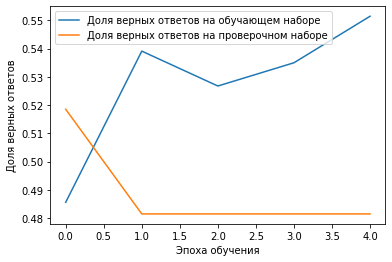

In [ ]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем набор данных для тестирования

In [ ]:
test = pd.read_excel('/content/test.xlsx')

In [ ]:
test

,class,title,text,link,language
0,1,В Германии планировали убить канцлера Олафа Шо...,Немецкий князь Генрих XIII со своими ближайшим...,https://lenta.ru/articles/2022/12/15/reich/,rus
1,1,Албанцы силой захватили власть на севере Косова,Албанцы провели силовой захват власти в муници...,https://lenta.ru/news/2022/12/14/kosowo/,rus
2,1,Посол покинул съезд партии в Сербии после виде...,Посол России в Сербии Александр Боцан-Харченко...,https://lenta.ru/news/2022/12/18/psll/,rus
3,1,Команда Байдена начала подготовку к его предвы...,Команда президента США Джо Байдена начала план...,https://lenta.ru/news/2022/12/18/biden/,rus
4,1,Сборная Хорватии стала бронзовым призером чемп...,Сборная Хорватии по футболу обыграла команду М...,https://lenta.ru/news/2022/12/17/croatiamorocco/,rus
...,...,...,...,...,...
67,1,"Coupe du monde 2022 : la Croatie, troisième, s...",Vous pouvez partager un article en cliquant su...,https://www.lemonde.fr/football/article/2022/1...,frn
68,1,"Iran : arrestation de Taraneh Alidoosti, célèb...",Vous pouvez partager un article en cliquant su...,https://www.lemonde.fr/international/article/2...,frn
69,0,"A part la dinde, y aura qui à Noël ? Les absen...",Vous pouvez partager un article en cliquant su...,https://www.lemonde.fr/m-perso/article/2022/12...,frn
70,0,Arts : l’Afghanistan sous l’œil de ses artiste...,Vous pouvez partager un article en cliquant su...,https://www.lemonde.fr/culture/article/2022/12...,frn


Преобразуем новости в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['text'])

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [ ]:
x_test[:5]

array([[5525,  387, 7642, ..., 4463, 4404, 4442],
       [   0,    0,    0, ...,   30, 1603, 3702],
       [   0,    0,    0, ...,   71, 3728, 2038],
       [   0,    0,    0, ...,  291,  851, 7785],
       [   0,    0,    0, ..., 2794,   39,  237]], dtype=int32)

Правильные ответы

In [ ]:
y_test = utils.to_categorical(test['class'], nb_classes)

In [ ]:
y_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.

## Оцениваем качество работы сети на тестовом наборе данных

### Сеть LSTM

In [ ]:
model_lstm.load_weights(model_lstm_save_path)

Оцениваем качество работы сети на тестовом наборе данных

In [ ]:
model_lstm.evaluate(x_test, y_test, verbose=1)

3/3 [==============================] - 0s 14ms/step - loss: 0.6929 - accuracy: 0.5417


[0.6928994655609131, 0.5416666865348816]

**Оцениваем качество работы сети на новых данных**

In [ ]:
text = '''Supporters of former Brazilian President Jair Bolsonaro on Sunday breached security barriers set up by the Armed Forces and gained access to key buildings for each of the three branches of government, including the congressional building, the Supreme Court and the Planalto Presidential Palace, according to images shown in Brazilian media.

Footage showed massive crowds in the capital of Brasília walking up a ramp that leads to the congressional building, where they had reached the Green Room, located outside the lower House of Congress’ chamber, Interim Senate President Veneziano Vital do Rogo told CNN Brasil.

Other outlets showed Bolsonaro suporters entering the Supreme Court and the presidential palace, where CNN Brasil showed the arrivals of anti-riot police and the Brazilian Armed Forces. Inside, protesters were using furniture to build barricades to prevent police from entering, CNN Brasil reported.

The floor of the Congress building was flooded after the sprinkler system activated when protesters attempted to set fire to the carpet, according to CNN Brasil.'''

In [ ]:
sequence = tokenizer.texts_to_sequences([text])

In [ ]:
sequence

[[999,
  3,
  152,
  97,
  6839,
  9,
  298,
  255,
  4813,
  417,
  74,
  20,
  1,
  1311,
  250,
  5,
  2979,
  1115,
  2,
  571,
  2843,
  8,
  507,
  3,
  1,
  143,
  4112,
  3,
  140,
  127,
  1,
  6413,
  870,
  1,
  1773,
  274,
  5,
  1,
  969,
  128,
  2,
  862,
  2950,
  6,
  201,
  2882,
  543,
  1641,
  6,
  1,
  622,
  3,
  6844,
  4724,
  74,
  4,
  3515,
  7,
  2,
  1,
  6413,
  870,
  131,
  35,
  49,
  1325,
  1,
  2689,
  989,
  2878,
  449,
  1,
  1543,
  188,
  3,
  3533,
  766,
  97,
  3106,
  144,
  149,
  339,
  104,
  2665,
  543,
  6839,
  4093,
  1,
  1773,
  274,
  5,
  1,
  969,
  131,
  339,
  543,
  1,
  6581,
  3,
  1302,
  6590,
  98,
  5,
  1,
  1311,
  250,
  838,
  801,
  46,
  360,
  2,
  1173,
  2,
  2126,
  98,
  18,
  4093,
  339,
  461,
  1,
  1694,
  3,
  1,
  331,
  870,
  16,
  55,
  1,
  375,
  69,
  801,
  2258,
  2,
  417,
  744,
  2,
  1,
  6468,
  128,
  2,
  339]]

In [ ]:
data = pad_sequences(sequence, maxlen=max_news_len)

In [ ]:
data

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [ ]:
data = utils.to_categorical(nb_classes)

In [ ]:
data

array([0., 0., 1.], dtype=float32)